**Credits / Attribution:** Rights for this code are held by **HydroAI Lab at GIST**, and initialization is by **Dr. Hyunglok Kim**.

# 2-Layer Water Balance Bucket Model with Saxton–Rawls PTFs + Texture-Based Priors for $K_s$ and $\beta$

This notebook implements a one and two-layer bucket model for soil moisture and integrates:
- **Saxton–Rawls (2006) pedotransfer functions (PTFs)** to estimate $\theta_{sat}$, $\theta_{fc}$, and $\theta_{w}$ from soil texture (sand %, clay %) and organic matter (OM %).
- **Texture-based priors for drainage parameters** $K_s$ [mm $d^{-1}$] and $\beta$ [–], which provide realistic starting values based on sand/clay content (sandy → larger $K_s$, smaller $\beta$; clayey → smaller $K_s$(e.g., 1), larger $\beta$(e.g., 6)).

## What you will be able to do

(1) Understand the governing equations and assumptions of a daily bucket model.  
(2) Estimate $\theta_{sat}$, $\theta_{fc}$, $\theta_{w}$ from sand, clay, and organic matter.  
(3) **Obtain texture-based priors for $K_s$ and $\beta$** to initialize drainage behavior without site calibration.  
(4) Build complete model parameters directly from texture, OM, and a chosen root depth $Z_r$.  
(5) Run a quick demo with synthetic forcing and visualize outputs (e.g., $S$, $ET$, $D$, $Q$).  
(6) Swap in your own $P$ and $PET$ time series and your site texture to produce relative soil moisture $s = S/W$.

---
# Acronyms
$S$: root-zone water storage [mm]  
$W$: storage capacity [mm]:
   $W = \text{porosity} \times Z_r \times 1000$
with porosity $\approx \theta_{sat}$ and $Z_r$ = root depth [m]  
$s$: relative storage, $s = S/W \in [0,1]$  
$P$: precipitation [mm $d^{-1}$]  
$PET$: potential evapotranspiration [mm $d^{-1}$]  
$ET$: actual evapotranspiration [mm $d^{-1}$]  
$D$: drainage (deep percolation) [mm $d^{-1}$]  
$Q$: surface runoff [mm $d^{-1}$]  
$K_s$: drainage scale parameter [mm $d^{-1}$], larger $\Rightarrow$ faster drainage near saturation  
$\beta$: drainage exponent [–], larger $\Rightarrow$ stronger nonlinearity near saturation  
$\theta_{sat}$, $\theta_{fc}$, $\theta_w$: saturated, field capacity (≈ −33 kPa), and wilting (≈ −1500 kPa) volumetric water contents [m$^3$ m$^{-3}$]  
$s_w = \theta_w/\theta_{sat}$, $s_{fc} = \theta_{fc}/\theta_{sat}$: relative thresholds for ET stress  

** Runoff options **

* (1) Saturation-excess (Dunne): $Q_t = \max(0,\ S_t + P_t - W)$
* (2) Hortonian (infiltration-excess): $I_t = \min(P_t, f_c)$, $Q_t = \max(0,\ P_t - f_c)$  
---

## 1. Model equations and concepts

We track a single state $S$ which is the root-zone water storage in millimeters. The bucket capacity is $W$ in millimeters.

**(1) State definition**  
- $S_t$ is the root-zone water storage at the end of day $t$, in mm.  
- $W$ is the storage capacity in mm.  
- Relative storage $s_t = \dfrac{S_t}{W} \in [0, 1]$.

**(2) Capacity**  
- $W = \text{porosity} \times \text{root\_depth\_m} \times 1000$.  
- $\text{porosity} \approx \theta_{sat}$.  
- $\text{root\_depth\_m}$ is the effective root depth in meters.

**(3) Water balance per day**
$$
S_{t+1} = \mathrm{clip}\!\left( S_t + I_t - ET_t - D_t - Q_t,\ 0,\ W \right)
$$

Where:  
- $P_t$ is precipitation [mm $d^{-1}$].  
- $I_t$ is infiltration [mm $d^{-1}$].  
- $ET_t$ is actual evapotranspiration [mm $d^{-1}$].  
- $D_t$ is deep drainage/percolation [mm $d^{-1}$].  
- $Q_t$ is surface runoff [mm $d^{-1}$].

**(4) Runoff and infiltration modes**  
- *Saturation-excess:*
  $$
  Q_t = \max(0,\ S_t + P_t - W), \qquad I_t = \min\!\left(P_t,\ \max(0,\ W - S_t)\right).
  $$
- *Hortonian (infiltration-excess):*
  $$
  I_t = \min(P_t,\ f_c), \qquad Q_t = \max(0,\ P_t - I_t),
  $$
  where $f_c$ is the infiltration capacity [mm $d^{-1}$].

**(5) Evapotranspiration with soil moisture stress**  
Let $PET_t$ be potential ET [$mm d^{-1}$]. We use a piecewise-linear stress function $f_{ET}(s)$:
$$
f_{ET}(s) =
\begin{cases}
0, & s \le s_w\\[4pt]
\dfrac{s - s_w}{s_{fc} - s_w}, & s_w < s < s_{fc}\\[8pt]
1, & s \ge s_{fc}
\end{cases}
$$

Then
$$
ET_t = PET_t \cdot f_{ET}(s_t),
$$
with relative thresholds
$$
s_w = \frac{\theta_w}{\theta_{sat}},\qquad
s_{fc} = \frac{\theta_{fc}}{\theta_{sat}}.
$$

**(6) Deep drainage**  
$$
D_t = K_s \cdot s_t^{\beta},
$$
where $K_s$ is in mm $d^{-1}$ and $\beta \in [1,6]$ typically.

**(7) Determining soil hydraulic parameters**

To apply the model, we need to estimate $\theta_{sat}$, $\theta_{fc}$, $\theta_{w}$, $K_s$, and $\beta$. These can be obtained from **soil texture and organic matter** using pedotransfer functions (PTFs):

- **Saturated water content ($\theta_{sat}$)**  
  Approximated by total soil porosity. Estimated from bulk density $\rho_b$ and particle density $\rho_p \approx 2.65$ g $cm^{-3}$:  
  $$
  \theta_{sat} = 1 - \frac{\rho_b}{\rho_p}
  $$
  or via texture-based regression equations (Saxton–Rawls 2006).

- **Field capacity ($\theta_{fc}$)** and **wilting point ($\theta_{w}$)**  
  Estimated from PTFs relating soil water content to suction at −33 kPa (field capacity) and −1500 kPa (wilting).  
  Saxton–Rawls equations use sand (%), clay (%), and organic matter (%) to provide these estimates.

- **Saturated hydraulic conductivity ($K_s$)**  
  Texture-dependent parameter that decreases strongly with clay content.  
  Typical values (mm d$^{-1}$):  
  - Sand: 300–1000  
  - Loam: 50–200  
  - Clay: 5–50  
  In PTFs, $K_s$ is predicted from texture and bulk density.

- **Drainage exponent ($\beta$)**  
  Controls nonlinearity of drainage.  
  - Sandy soils: $\beta \approx 2$ (drainage increases quickly with $s$)  
  - Loamy soils: $\beta \approx 3$–$4$  
  - Clay soils: $\beta \approx 5$–$6$ (drainage suppressed until near saturation)  

Thus, given **sand, clay, organic matter, and bulk density**, you can use Saxton–Rawls (2006) PTFs (or similar) to estimate $\theta_{sat}$, $\theta_{fc}$, $\theta_{w}$, and to assign **texture-based priors** for $K_s$ and $\beta$ as starting values for simulation.


## 2. Inputs, outputs, and units

**(1) Required inputs per day**  
- $P$ in mm $d^{-1}$  
- $PET$ in mm $d^{-1}$

**(2) Model parameters**  
- $\text{porosity} \approx \theta_{sat} \in [0,1]$  
- $\text{root\_depth\_m}$ in meters  
- $s_w, s_{fc} \in [0,1]$ with $s_w < s_{fc}$  
- $K_s$ in mm $d^{-1}$  
- $\beta$ unitless

**(3) Outputs**  
- $S$ storage in mm  
- $s$ relative soil moisture $[0,1]$  
- $ET$, $D$, $Q$, $I$ in mm $d^{-1}$


## 3. Saxton–Rawls PTFs for $\theta$ values

The Saxton–Rawls (2006) pedotransfer functions estimate soil water retention based on **sand (%), clay (%), and organic matter (OM, % by weight)**. They provide estimates for:

- $\theta_{sat}$: saturated water content (approximately porosity).  
- $\theta_{fc}$: volumetric water content at field capacity ($\psi \approx -33$ kPa).  
- $\theta_{w}$: volumetric water content at wilting point ($\psi \approx -1500$ kPa).  

All are expressed as volumetric fractions [$m^3$ $m^{-3}$].  

The relative thresholds used in the bucket model are:
$$
s_w = \frac{\theta_{w}}{\theta_{sat}}, 
\qquad
s_{fc} = \frac{\theta_{fc}}{\theta_{sat}}.
$$

---

### Saxton–Rawls regression equations

Let  
- $S$ = sand fraction [% by weight],  
- $C$ = clay fraction [% by weight],  
- $OM$ = organic matter fraction [% by weight],  
- $\rho_b$ = bulk density [g $cm^{-3}$].

1. **Saturated water content (porosity)**  
   $$
   \theta_{sat} = 0.332 - 0.000725 S + 0.1276 \ln(C + OM) + 0.356\, OM - 0.00258 \rho_b S
   $$

2. **Field capacity (at −33 kPa)**  
   $$
   \theta_{fc} = -0.251 S + 0.195 C + 0.011 OM + 0.006 \rho_b + 0.14
   $$

3. **Wilting point (at −1500 kPa)**  
   $$
   \theta_{w} = -0.024 S + 0.487 C + 0.006 OM + 0.005 \rho_b + 0.028
   $$

*(coefficients simplified from Saxton & Rawls, 2006; note that different published forms exist depending on whether input is % or fraction — here all inputs are in % by weight, OM also in %).*

---

### Typical ranges by soil texture

- **Sands:** $\theta_{sat} \approx 0.35$, $\theta_{fc} \approx 0.10$, $\theta_{w} \approx 0.04$.  
- **Loams:** $\theta_{sat} \approx 0.43$, $\theta_{fc} \approx 0.25$, $\theta_{w} \approx 0.12$.  
- **Clays:** $\theta_{sat} \approx 0.48$, $\theta_{fc} \approx 0.38$, $\theta_{w} \approx 0.25$.  

---

If **site-specific lab measurements** exist, those should be used. Otherwise, the Saxton–Rawls PTFs are a practical and widely used alternative.

## 4. Texture‑based estimates for $K_s$ and $\beta$

We parameterize drainage in the bucket as
$$
D_t \;=\; K_s\, s_t^{\beta},
$$
where $K_s$ [mm $d^{-1}$] sets the overall drainage rate and $\beta$ [–] controls how sharply drainage increases as $s \to 1$.

When site calibration is not available, use **texture‑based priors** derived from sand (%) and clay (%) to initialize $(K_s,\beta)$.

**Inputs (percent by weight)**
$$
S = \text{sand (\%)},\qquad C = \text{clay (\%)},\qquad
s_n = \frac{S}{100},\qquad c_n = \frac{C}{100}.
$$

**Smooth priors (bucket‑scale, not lab $K_{sat}$)**
$$
K_s^{(0)} \;=\; \mathrm{clip}\!\Big( 1.5 \;+\; 10.5\,[\,0.7\,s_n \;+\; 0.3\,(1-c_n)\,]\;,\; 0.5\;,\; 20 \Big)\ \text{mm}\ d^{-1},
$$

$$
\beta^{(0)} \;=\; \mathrm{clip}\!\Big( 2.3 \;+\; 2.5\,[\,0.7\,c_n \;+\; 0.3\,(1-s_n)\,]\;,\; 2.0\;,\; 5.5 \Big).
$$

**Interpretation (rules of thumb)**

Sandy: $K_s^{(0)} \approx 8$–15 mm $d^{-1}$, $\beta^{(0)} \approx 2.2$–3.0  

Loam: $K_s^{(0)} \approx 3$–6 mm $d^{-1}$, $\beta^{(0)} \approx 3.0$–4.0  

Clay: $K_s^{(0)} \approx 1$–3 mm $d^{-1}$, $\beta^{(0)} \approx 4.0$–5.5  

These are **starting values**. If you have observed soil moisture, calibrate $(K_s,\beta)$ to your site while keeping the water balance physics unchanged.

## 4‑B. Texture‑class lookup priors for $K_s$ and $\beta$

When a **USDA soil texture class** is known (e.g., “loam”, “sandy clay loam”), we can assign **bucket‑scale drainage priors** directly from literature ranges:

- $K_s$ [mm $d^{-1}$]: effective drainage scale for the bucket (smaller than lab $K_{sat}$).
- $\beta$ [–]: drainage nonlinearity; higher $\beta$ = stronger increase as $s \to 1$.

The table below encodes typical **mid‑range priors** for each texture class.  
If you **don’t** know the class, you can (optionally) use a **coarse classifier** from sand/clay to a USDA class, or fall back to the **smooth sand/clay heuristic** described above.

**References (for typical ranges, not exact formulas):**
- Rawls & Saxton tabulations of hydraulic properties by texture (e.g., Rawls et al. 1982; Saxton & Rawls 2006).  
- Nonlinear conductivity forms (shape exponents) follow the Mualem–van Genuchten family.

> Note: These priors are **starting values** for a one‑layer bucket. If you have site observations, calibrate $K_s$ and $\beta$.

## 5. Imports

In [29]:
import numpy as np
from dataclasses import dataclass
from typing import Optional, Literal, Tuple, Dict
import matplotlib.pyplot as plt


## 6. Bucket model implementation

This cell defines the parameter class and the main simulation function. The water balance step is:
$$
S_{t+1} = \mathrm{clip}\!\left( S_t + I_t - ET_t - D_t - Q_t,\ 0,\ W \right),
$$
with $ET_t = PET_t \cdot f_{ET}(s_t)$ and $D_t = K_s \cdot s_t^{\beta}$.


In [20]:
@dataclass
class BucketParams:
    porosity: float = 0.40
    root_depth_m: float = 0.5
    s_w: float = 0.15
    s_fc: float = 0.75
    K_s: float = 4.0
    beta: float = 3.5
    infil_capacity: Optional[float] = None

def simulate_bucket(
    P: np.ndarray,
    PET: np.ndarray,
    params: BucketParams = BucketParams(),
    S0: Optional[float] = None,
    runoff_type: Literal["saturation", "horton"] = "saturation",
) -> Dict[str, np.ndarray]:
    P = np.asarray(P, dtype=float).ravel()
    PET = np.asarray(PET, dtype=float).ravel()
    assert P.shape == PET.shape, "P and PET must have the same shape"

    T = P.size
    W = params.porosity * params.root_depth_m * 1000.0 # water holding capacity mm
    S_prev = 0.5 * W if S0 is None else float(S0)
    S_prev = np.clip(S_prev, 0.0, W)

    S = np.empty(T); s = np.empty(T); ET = np.empty(T)
    D = np.empty(T); Q = np.empty(T); I = np.empty(T)

    for t in range(T):
        s_prev = S_prev / W # relative saturation

        # ET stress factor
        if s_prev <= params.s_w: # if less than wilting point, no ET (because vegetation cannot extract water from the soil)
            f_et = 0.0
        elif s_prev >= params.s_fc: # if greater than field capacity, ET is at full potential
            f_et = 1.0
        else: # if between wilting point and field capacity, ET is a function of the relative saturation
            denom = max(1e-6, params.s_fc - params.s_w)
            f_et = (s_prev - params.s_w) / denom

        et = PET[t] * max(0.0, min(1.0, f_et)) # actual ET mm d-1
        d  = params.K_s * (s_prev ** params.beta) # drainage rate mm d-1

        if runoff_type == "saturation":
            q = max(0.0, S_prev + P[t] - W) # runoff mm d-1
            i = min(P[t], max(0.0, W - S_prev)) # infiltration mm d-1
        elif runoff_type == "horton":
            fc = np.inf if params.infil_capacity is None else params.infil_capacity
            i = min(P[t], fc) # infiltration mm d-1
            q = max(0.0, P[t] - i) # runoff mm d-1
        else:
            raise ValueError("runoff_type must be 'saturation' or 'horton'")

        S_new = S_prev + i - et - d - q
        S_new = min(max(S_new, 0.0), W)

        S[t] = S_new; s[t] = S_new / W
        ET[t] = et; D[t] = d; Q[t] = q; I[t] = i
        S_prev = S_new

    return dict(S=S, s=s, ET=ET, D=D, Q=Q, I=I, P=P, PET=PET, W=np.full(T, W))


## 7. Saxton–Rawls PTF implementation

The Saxton–Rawls (2006) pedotransfer functions (PTFs) estimate soil water retention based on sand (%), clay (%), and organic matter (OM, %). They provide $\theta_{sat}$, $\theta_{fc}$, and $\theta_{w}$ as volumetric water contents [$m^3$ $m^{-3}$].  

These values are often used in bucket models to define porosity (capacity), field capacity, and wilting point thresholds. Relative thresholds are then:
$$
s_w = \frac{\theta_w}{\theta_{sat}}, \qquad
s_{fc} = \frac{\theta_{fc}}{\theta_{sat}}.
$$

### Physically consistent clipping for Saxton–Rawls outputs

The function `saxton_rawls_with_clipper(...)` combines three steps in one call:  

1. **PTF evaluation**  
   Computes $\theta_{sat}$, $\theta_{fc}$, $\theta_{w}$ from Saxton–Rawls equations (with inputs given as % or fractions).  

2. **Compaction adjustment**  
   An optional `density_factor` (e.g., 0.9 loose, 1.2 compacted) modifies $\theta_{sat}$ and $\theta_{fc}$ to account for bulk density changes.  

3. **Physically consistent clipping**  
   Enforces texture-aware and monotonic consistency:  

   - **Texture-aware $\theta_{sat}$ bounds.**  
     Prevents extreme sands from exceeding loams/clays by constraining $\theta_{sat}$ to conservative mid-range envelopes for each USDA class.  

   - **Monotonic water contents.**  
     Ensures $\theta_w < \theta_{fc} < \theta_{sat}$ (with small safety margins `d_w_fc` and `d_fc_sat`), correcting cases where the regression produces unrealistic ordering.  

   - **Relative thresholds updated.**  
     After clipping, $s_w=\theta_w/\theta_{sat}$ and $s_{fc}=\theta_{fc}/\theta_{sat}$ are recalculated to stay consistent.  

**How it picks bounds**

- If you provide `texture_class` (e.g., `"loam"`), the class envelope is used directly.  
- Otherwise, it **infers** a USDA class from sand/clay (`use_coarse_classifier=True`), or skips class bounds if disabled.  
- These envelopes are **bucket-scale conservative ranges** (not laboratory $K_{sat}$ values).  

**Outputs**
- Dictionary with:
  - `theta_sat`, `theta_fc`, `theta_w` [$m^3$ $m^{-3}$]  
  - `s_fc`, `s_w`  
  - metadata: `density_factor`, and if used, `texture_class_used`, `theta_sat_bounds_used`

> Use this function as a **guardrail** for PTF outputs. If laboratory measurements exist for your site, prefer those over PTFs and clippers.

In [17]:
# ------------------------
# Helpers and lookups
# ------------------------
def _as_fraction(x: float) -> float:
    """Accept 0..100 (%) or 0..1 (fraction); return fraction in 0..1."""
    x = float(x)
    return x/100.0 if x > 1.0 else x

def _coarse_usda_class_from_sand_clay(sand_pct: float, clay_pct: float) -> str:
    """Very coarse sand/clay -> USDA class (good enough for bounding)."""
    S = float(np.clip(sand_pct, 0.0, 100.0))
    C = float(np.clip(clay_pct, 0.0, 100.0))
    Z = float(np.clip(100.0 - S - C, 0.0, 100.0))  # silt (approx.)

    if C >= 55: return "clay"
    if C >= 40 and S <= 45: return "silty clay" if Z >= 40 else "sandy clay"
    if 35 <= C < 40:
        if Z >= 40: return "silty clay loam"
        if S >= 45: return "sandy clay"
        return "clay"
    if 27 <= C < 35:
        if S >= 45: return "sandy clay loam"
        if Z >= 40: return "silty clay loam"
        return "clay loam"
    if 20 <= C < 27:
        if S >= 52: return "sandy clay loam"
        if Z >= 50: return "silt loam"
        return "loam"
    if 7 <= C < 20:
        if S >= 52: return "sandy loam"
        if Z >= 50: return "silt loam"
        return "loam"
    if C < 7:
        if S >= 85: return "sand"
        if S >= 70: return "loamy sand"
        if S >= 43: return "sandy loam"
        if Z >= 80: return "silt"
        return "silt loam"
    return "loam"

# Conservative bucket-scale envelopes for theta_sat by USDA class (m3 m-3)
_THETA_SAT_BOUNDS: Dict[str, Tuple[float, float]] = {
    "sand":              (0.30, 0.42),
    "loamy sand":        (0.32, 0.44),
    "sandy loam":        (0.36, 0.47),
    "loam":              (0.40, 0.52),
    "silt loam":         (0.43, 0.55),
    "silt":              (0.43, 0.56),
    "sandy clay loam":   (0.41, 0.53),
    "clay loam":         (0.42, 0.55),
    "silty clay loam":   (0.45, 0.58),
    "sandy clay":        (0.43, 0.56),
    "silty clay":        (0.47, 0.60),
    "clay":              (0.48, 0.60),
}

# ------------------------
# Core Saxton–Rawls (2006)
# ------------------------
def _saxton_rawls_core(S: float, C: float, OM: float) -> Tuple[float, float, float]:
    """
    Core PTF regressions with S,C,OM as fractions (0..1).
    Returns (theta_w, theta_fc, theta_sat) *before* any density adjustment.
    """
    # Wilting point (u1500)
    th1500_t = -0.024*S + 0.487*C + 0.006*OM + 0.005*(S*OM) - 0.013*(C*OM) + 0.068*(S*C) + 0.031
    th1500   = th1500_t + (0.14*th1500_t - 0.02)

    # Field capacity (u33)
    th33_t = -0.251*S + 0.195*C + 0.011*OM + 0.006*(S*OM) - 0.027*(C*OM) + 0.452*(S*C) + 0.299
    th33   = th33_t + (1.283*(th33_t**2) - 0.374*th33_t - 0.015)

    # Saturation increment u(S-33) and saturation uS
    thS33_t = 0.278*S + 0.034*C + 0.022*OM - 0.018*(S*OM) - 0.027*(C*OM) - 0.584*(S*C) + 0.078
    thS33   = thS33_t + (0.636*thS33_t - 0.107)
    ths     = th33 + thS33 - 0.097*S + 0.043
    return th1500, th33, ths

def saxton_rawls_with_clipper(
    sand_pct: float,
    clay_pct: float,
    om_pct: float,
    *,
    density_factor: float = 1.0,
    texture_class: Optional[str] = None,
    use_coarse_classifier: bool = True,
    d_fc_sat: float = 0.01,
    d_w_fc: float  = 0.01,
) -> Dict[str, float]:
    """
    One-stop Saxton–Rawls (2006):
      1) PTF on texture/OM (accepts % or fractions; auto-normalized),
      2) optional density/compaction adjustment via 'density_factor',
      3) physically consistent clipping (class-based theta_sat bounds + monotonicity).

    Returns dict with theta_sat, theta_fc, theta_w, s_fc, s_w and metadata.
    """

    # 1) Normalize inputs to fractions
    S = _as_fraction(sand_pct)
    C = _as_fraction(clay_pct)
    OM = _as_fraction(om_pct)

    # 2) PTF regressions
    th1500, th33, ths = _saxton_rawls_core(S, C, OM)

    # 3) Optional density/compaction tweak
    if density_factor != 1.0:
        rho_N = (1.0 - ths) * 2.65
        rho_DF = rho_N * density_factor
        ths_DF = 1.0 - (rho_DF / 2.65)
        th33_DF = th33 - 0.2*(ths - ths_DF)
        th1500_DF = th1500
        ths, th33, th1500 = ths_DF, th33_DF, th1500_DF

    # 4) Clamp to broad physical range before class bounds
    ths    = float(np.clip(ths,    0.0, 0.8))
    th33   = float(np.clip(th33,   0.0, 0.8))
    th1500 = float(np.clip(th1500, 0.0, 0.8))

    # 5) Optional texture-class bounding for theta_sat
    cls_used = None
    if texture_class:
        key = " ".join(texture_class.lower().split())
        if key in _THETA_SAT_BOUNDS:
            cls_used = key
    elif use_coarse_classifier:
        key = _coarse_usda_class_from_sand_clay(sand_pct, clay_pct)
        if key in _THETA_SAT_BOUNDS:
            cls_used = key

    if cls_used:
        lo, hi = _THETA_SAT_BOUNDS[cls_used]
        ths = float(np.clip(ths, lo, hi))
    else:
        lo = hi = None

    # 6) Enforce monotonicity with margins: theta_w < theta_fc < theta_sat
    th33   = min(th33,   ths - d_fc_sat)
    th1500 = min(th1500, th33 - d_w_fc)
    th1500 = max(th1500, 0.0)
    th33   = max(th33,   th1500 + d_w_fc)
    ths    = max(ths,    th33   + d_fc_sat)

    # 7) Relative thresholds
    s_fc = th33/ths if ths > 1e-12 else None
    s_w  = th1500/ths if ths > 1e-12 else None

    out = dict(theta_sat=ths, theta_fc=th33, theta_w=th1500, s_fc=s_fc, s_w=s_w)
    out["density_factor"] = density_factor
    if cls_used:
        out["texture_class_used"] = cls_used
        out["theta_sat_bounds_used"] = (lo, hi)
    return out


# ---- tiny examples ----
# Sandy soil (loose vs compacted) with inferred class bounds
print("Sandy (S=90%, C=5%, OM=1%), DF=1.0:")
print(saxton_rawls_with_clipper(90, 5, 1.0))

print("\nSandy (S=90%, C=5%, OM=1%), DF=1.2 (compacted):")
print(saxton_rawls_with_clipper(90, 5, 1.0, density_factor=1.2))

# Loam with explicit class bounds
print("\nLoam (S=40%, C=20%, OM=2%), explicit class='loam':")
print(saxton_rawls_with_clipper(40, 20, 2.0, texture_class="loam"))

# Clayey soil, no class bounds (turn off inference)
print("\nClay (S=20%, C=60%, OM=2%), no class bounds:")
print(saxton_rawls_with_clipper(20, 60, 2.0, use_coarse_classifier=False))

Sandy (S=90%, C=5%, OM=1%), DF=1.0:
{'theta_sat': 0.42, 'theta_fc': 0.07695547502079998, 'theta_w': 0.0331924, 's_fc': 0.1832273214780952, 's_w': 0.0790295238095238, 'density_factor': 1.0, 'texture_class_used': 'sand', 'theta_sat_bounds_used': (0.3, 0.42)}

Sandy (S=90%, C=5%, OM=1%), DF=1.2 (compacted):
{'theta_sat': 0.31558959402496, 'theta_fc': 0.054141794821631985, 'theta_w': 0.0331924, 's_fc': 0.17155760470780893, 's_w': 0.10517583795039455, 'density_factor': 1.2, 'texture_class_used': 'sand', 'theta_sat_bounds_used': (0.3, 0.42)}

Loam (S=40%, C=20%, OM=2%), explicit class='loam':
{'theta_sat': 0.4, 'theta_fc': 0.25274018949120003, 'theta_w': 0.12175672, 's_fc': 0.6318504737280001, 's_w': 0.3043918, 'density_factor': 1.0, 'texture_class_used': 'loam', 'theta_sat_bounds_used': (0.4, 0.52)}

Clay (S=20%, C=60%, OM=2%), no class bounds:
{'theta_sat': 0.5281381572528001, 'theta_fc': 0.4741730532528, 'theta_w': 0.35226015999999993, 's_fc': 0.897820100178505, 's_w': 0.6669848697021641,

### 8. Texture‑based priors for $K_s$ and $\beta$: three selectable options

Use the function `ks_beta_priors_from_texture(...)` to obtain **bucket‑scale** drainage priors:
- **Modes**
  - `mode="smooth"`: continuous heuristic mapping from sand and clay to $K_s$ [mm $d^{-1}$] and $\beta$ [–].
  - `mode="lookup"`: provide a USDA texture class (e.g., `"loam"`, `"sandy clay loam"`) and get mid‑range priors.
  - `mode="coarse_lookup"`: infer a USDA class from sand/clay with a quick rule set, then apply the lookup.

**Inputs**
- `sand_pct`, `clay_pct`: percent by weight (0–100).  
- `texture_class` (optional): USDA class string (used when `mode="lookup"`).  
- `params`: `KsBetaPriorParams` dataclass to adjust weights, base/spans, and bounds for the **smooth** mode.

**Outputs**
- Dictionary with `Ks` (mm $d^{-1}$), `beta` (–), `source`, and (when applicable) `texture_class`.

**Notes**
- Values are intended for a **one‑layer bucket** (effective drainage), not lab \(K_{sat}\).  
- Treat these as **starting points**—calibrate to site observations if available.  
- Typical ranges: sandy → higher $K_s$, lower $\beta$; clayey → lower $K_s$, higher $\beta$.

In [ ]:
# ---------------------------
# Tuning for the SMOOTH mode
# ---------------------------
@dataclass
class KsBetaPriorParams:
    """
    Tuning knobs for texture-based priors of Ks and beta
    (used ONLY when mode='smooth').

    Ks (mm d^-1) increases with sand and decreases with clay.
    beta (–) increases with clay and decreases with sand.

    Adjust weights, bases, spans, and bounds if you have local knowledge.
    """
    # weights for the texture influence (0..1)
    w_sand_for_Ks: float = 0.7   # importance of sand for Ks
    w_clay_for_beta: float = 0.7 # importance of clay for beta

    # base + span maps the [0,1] score into a plausible bucket-scale range
    Ks_base: float  = 1.5        # mm d^-1 at low score
    Ks_span: float  = 10.5       # added when score = 1
    beta_base: float = 2.3       # at low score
    beta_span: float = 2.5       # added when score = 1

    # hard bounds for clipping (bucket-scale, not lab Ksat)
    Ks_min: float = 0.5
    Ks_max: float = 20.0
    beta_min: float = 2.0
    beta_max: float = 5.5

# ---------------------------
# LOOKUP table by USDA class
# ---------------------------
_USDA_CLASS_PRIORS: Dict[str, Tuple[float, float]] = {
    # class_name (lowercase): (Ks [mm d^-1], beta [-])
    "sand":               (12.0, 2.3),
    "loamy sand":         (11.0, 2.5),
    "sandy loam":         (9.0,  2.7),
    "loam":               (5.0,  3.3),
    "silt loam":          (4.0,  3.4),
    "silt":               (4.0,  3.2),
    "sandy clay loam":    (4.0,  3.8),
    "clay loam":          (3.5,  4.0),
    "silty clay loam":    (3.0,  4.3),
    "sandy clay":         (2.5,  4.6),
    "silty clay":         (2.0,  4.8),
    "clay":               (1.5,  5.0),
}

def _priors_from_usda_class(texture_class: str) -> Dict[str, float]:
    key = " ".join(texture_class.lower().split())
    if key not in _USDA_CLASS_PRIORS:
        raise KeyError(f"Unrecognized USDA texture class: {texture_class!r}")
    Ks, beta = _USDA_CLASS_PRIORS[key]
    return {"Ks": float(Ks), "beta": float(beta), "texture_class": key, "source": "usda_lookup"}

# ---------------------------------------
# Very coarse sand/clay -> USDA class map
# ---------------------------------------
def _coarse_usda_class_from_sand_clay(sand_pct: float, clay_pct: float) -> str:
    S = float(np.clip(sand_pct, 0.0, 100.0))
    C = float(np.clip(clay_pct, 0.0, 100.0))
    Z = float(np.clip(100.0 - S - C, 0.0, 100.0))  # silt (approx.)

    # Coarse rules (good enough to be "in the neighborhood")
    if C >= 55:
        return "clay"
    if C >= 40 and S <= 45:
        return "silty clay" if Z >= 40 else "sandy clay"
    if 35 <= C < 40:
        if Z >= 40: return "silty clay loam"
        if S >= 45: return "sandy clay"
        return "clay"
    if 27 <= C < 35:
        if S >= 45: return "sandy clay loam"
        if Z >= 40: return "silty clay loam"
        return "clay loam"
    if 20 <= C < 27:
        if S >= 52: return "sandy clay loam"
        if Z >= 50: return "silt loam"
        return "loam"
    if 7 <= C < 20:
        if S >= 52: return "sandy loam"
        if Z >= 50: return "silt loam"
        return "loam"
    # Low clay:
    if C < 7:
        if S >= 85: return "sand"
        if S >= 70: return "loamy sand"
        if S >= 43: return "sandy loam"
        if Z >= 80: return "silt"
        return "silt loam"
    return "loam"

# ---------------------------
# SMOOTH sand/clay heuristic
# ---------------------------
def _smooth_ks_beta(sand_pct: float, clay_pct: float, params: KsBetaPriorParams) -> Dict[str, float]:
    S = float(np.clip(sand_pct, 0.0, 100.0))
    C = float(np.clip(clay_pct, 0.0, 100.0))
    s_n = S / 100.0
    c_n = C / 100.0

    score_K = params.w_sand_for_Ks * s_n + (1.0 - params.w_sand_for_Ks) * (1.0 - c_n)
    Ks0   = params.Ks_base  + params.Ks_span  * score_K
    score_b = params.w_clay_for_beta * c_n + (1.0 - params.w_clay_for_beta) * (1.0 - s_n)
    beta0 = params.beta_base + params.beta_span * score_b

    Ks0   = float(np.clip(Ks0,   params.Ks_min,   params.Ks_max))
    beta0 = float(np.clip(beta0, params.beta_min, params.beta_max))
    return {"Ks": Ks0, "beta": beta0, "source": "smooth_texture"}

# ----------------------------------------------------
# Unified selector: 'smooth' | 'lookup' | 'coarse_lookup'
# ----------------------------------------------------
def ks_beta_priors_from_texture(
    sand_pct: float,
    clay_pct: float,
    params: KsBetaPriorParams = KsBetaPriorParams(),
    *,
    mode: Literal["smooth", "lookup", "coarse_lookup"] = "smooth",
    texture_class: Optional[str] = None,
) -> Dict[str, float]:
    """
    Select bucket-scale priors for (Ks, beta) using one of three options:

      - mode='smooth':        continuous heuristic from sand/clay (uses 'params')
      - mode='lookup':        use an explicit USDA texture class (pass 'texture_class')
      - mode='coarse_lookup': infer a USDA class from sand/clay, then look it up

    Returns:
        dict with keys:
            Ks   (mm d^-1)
            beta (–)
            source (string indicating which method)
            texture_class (present for lookup/coarse_lookup)
    """
    if mode == "lookup":
        if not texture_class:
            raise ValueError("mode='lookup' requires 'texture_class' (e.g., 'loam').")
        out = _priors_from_usda_class(texture_class)
        return out

    if mode == "coarse_lookup":
        cls = _coarse_usda_class_from_sand_clay(sand_pct, clay_pct)
        out = _priors_from_usda_class(cls)
        out["texture_class_inferred"] = cls
        out["source"] = "coarse_classified_lookup"
        return out

    # default: smooth
    return _smooth_ks_beta(sand_pct, clay_pct, params)

# ---- tiny examples ----
# smooth mode
print(ks_beta_priors_from_texture(70, 10, mode="smooth"))
# lookup mode
print(ks_beta_priors_from_texture(70, 10, mode="lookup", texture_class="sandy loam"))
# coarse lookup mode
print(ks_beta_priors_from_texture(70, 10, mode="coarse_lookup"))
# lookup mode with clay loam
print(ks_beta_priors_from_texture(30, 40, mode="lookup", texture_class="clay loam"))

{'Ks': 9.48, 'beta': 2.6999999999999997, 'source': 'smooth_texture'}
{'Ks': 9.0, 'beta': 2.7, 'texture_class': 'sandy loam', 'source': 'usda_lookup'}
{'Ks': 9.0, 'beta': 2.7, 'texture_class': 'sandy loam', 'source': 'coarse_classified_lookup', 'texture_class_inferred': 'sandy loam'}
{'Ks': 3.5, 'beta': 4.0, 'texture_class': 'clay loam', 'source': 'usda_lookup'}


## 9. Building model parameters from texture

I build a ready‑to‑use `BucketParams` directly from **sand, clay, OM, and root depth**:

1) Compute $\theta_{sat}$, $\theta_{fc}$, $\theta_w$ via **Saxton–Rawls (2006)** using  
   `saxton_rawls_with_clipper(...)` (PTF → optional compaction via `density_factor` → physically consistent clipping).  
   Set **porosity** $\approx \theta_{sat}$ and derive ET‑stress thresholds $s_w=\theta_w/\theta_{sat}$, $s_{fc}=\theta_{fc}/\theta_{sat}$.

2) Choose **drainage priors** $(K_s,\beta)$ from texture using one of three modes in `ks_beta_priors_from_texture(...)`:
   - `mode="smooth"`: continuous heuristic from sand/clay to $K_s$ [mm $d^{-1}$] and $\beta$ [–].
   - `mode="lookup"`: provide a USDA texture class (e.g., `"loam"`, `"sandy clay loam"`), get mid‑range priors.
   - `mode="coarse_lookup"`: **infer** a USDA class from sand/clay with coarse rules, then apply the lookup.

**Inputs**
- `sand_pct`, `clay_pct`, `om_pct`: texture & OM as **% (0–100)** or **fractions (0–1)** (auto‑detected).  
- `root_depth_m`: effective rooting depth [m].  
- `density_factor`: compaction tweak for Saxton–Rawls (e.g., 0.9 loose, **1.0 default**, 1.2 compacted).  
- `ks_beta_mode`: one of `"smooth" | "lookup" | "coarse_lookup"`.  
- `texture_class` (optional): used when `ks_beta_mode="lookup"`.  
- `ks_params` (optional): `KsBetaPriorParams` to tune the **smooth** mode.

**Outputs**
- A `BucketParams` object with `porosity`, `s_w`, `s_fc`, `K_s`, `beta`, and `root_depth_m`, ready for simulation.

> Notes: Values are **bucket‑scale** (effective drainage), not laboratory \($K_{sat}$\). Use these as **starting points** and calibrate to site observations when available.

In [22]:
# --- Prereqs assumed available from previous sections ---
# - saxton_rawls_with_clipper(...)
# - ks_beta_priors_from_texture(..., mode=..., texture_class=..., params=...)
# - BucketParams dataclass

def params_from_texture_with_priors(
    sand_pct: float,
    clay_pct: float,
    om_pct: float,
    root_depth_m: float,
    *,
    density_factor: float = 1.0,
    ks_beta_mode: Literal["smooth", "lookup", "coarse_lookup"] = "smooth",
    texture_class: Optional[str] = None,
    ks_params: Optional[KsBetaPriorParams] = None,
) -> BucketParams:
    """
    Build BucketParams from texture:
      - θ via Saxton–Rawls + compaction + physical clipping
      - (Ks, beta) via selected texture-based prior mode
    """
    # 1) θ values and thresholds (porosity ≈ theta_sat)
    sr = saxton_rawls_with_clipper(
        sand_pct, clay_pct, om_pct,
        density_factor=density_factor,
        texture_class=texture_class,            # used for θ_sat bounds if provided
        use_coarse_classifier=(texture_class is None)  # infer if not provided
    )
    porosity = float(sr["theta_sat"])
    s_fc = float(sr["s_fc"])
    s_w  = float(sr["s_w"])

    # 2) Ks, beta priors from texture
    if ks_params is None:
        ks_params = KsBetaPriorParams()  # defaults for smooth mode

    kb = ks_beta_priors_from_texture(
        sand_pct, clay_pct,
        params=ks_params,
        mode=ks_beta_mode,
        texture_class=texture_class,
    )
    Ks   = float(kb["Ks"])
    beta = float(kb["beta"])

    # 3) Return parameter object
    return BucketParams(
        porosity=porosity,
        root_depth_m=float(root_depth_m),
        s_w=s_w,
        s_fc=s_fc,
        K_s=Ks,
        beta=beta,
    )

In [26]:
# Example A: Smooth mode (no class), compaction default
pars_smooth = params_from_texture_with_priors(
    sand_pct=55, clay_pct=22, om_pct=1.0,
    root_depth_m=0.5,
    ks_beta_mode="smooth",           # smooth heuristic
    density_factor=1.1               # slightly compacted
)
print("Smooth mode (S=55%, C=22%):", pars_smooth)

# Example B: Explicit class lookup ("loam")
pars_lookup = params_from_texture_with_priors(
    sand_pct=55, clay_pct=22, om_pct=1.0,
    root_depth_m=0.5,
    ks_beta_mode="lookup",           # use class mid-ranges
    texture_class="loam",            # explicit USDA class
    density_factor=1.1               # slightly compacted
)
print("Lookup mode (class='loam'):", pars_lookup)

# Example C: **Inferred** class from sand/clay, then lookup
pars_inferred = params_from_texture_with_priors(
    sand_pct=55, clay_pct=22, om_pct=1.0,
    root_depth_m=0.5,
    ks_beta_mode="coarse_lookup",    # infer USDA class from S,C
    density_factor=1.1
)
print("Coarse-lookup mode (class inferred):", pars_inferred)

Smooth mode (S=55%, C=22%): BucketParams(porosity=0.41, root_depth_m=0.5, s_w=0.33786858536585374, s_fc=0.5650953128615868, K_s=7.9995, beta=3.0225, infil_capacity=None)
Lookup mode (class='loam'): BucketParams(porosity=0.4, root_depth_m=0.5, s_w=0.34631530000000005, s_fc=0.5792226956831263, K_s=5.0, beta=3.3, infil_capacity=None)
Coarse-lookup mode (class inferred): BucketParams(porosity=0.41, root_depth_m=0.5, s_w=0.33786858536585374, s_fc=0.5650953128615868, K_s=4.0, beta=3.8, infil_capacity=None)


## 10. Demo with synthetic forcing

This cell shows how to build `BucketParams` from texture and run the model:

1) **Parameters from texture**  
   - $\theta_{sat}$, $\theta_{fc}$, $\theta_{w}$ via `saxton_rawls_with_clipper(...)`  
   - $s_w = \theta_w / \theta_{sat}$, $s_{fc} = \theta_{fc} / \theta_{sat}$  
   - $K_s, \beta$ via `ks_beta_priors_from_texture(...)` using a **mode**:
     - `"smooth"` — continuous heuristic from sand/clay  
     - `"lookup"` — provide an explicit USDA class (e.g., `"loam"`)  
     - `"coarse_lookup"` — infer a class from sand/clay and look it up

2) **Run the bucket** with daily precipitation $P$ and potential ET $PET$ [mm $d^{-1}$].

We print the derived thresholds and the first few days of fluxes for a quick sanity check.

In [49]:
# --- Example texture: silty loam-ish (S=20%, C=15%, OM=2%) ---
# We'll use ks_beta_mode="coarse_lookup" so the USDA class is inferred from sand/clay.
# If you want a fixed class, set ks_beta_mode="lookup" and texture_class="silt loam" (for example).

# Build parameters from texture with priors
sand, clay, om = 40, 55, 2.0
pars = params_from_texture_with_priors(
    sand_pct=sand,
    clay_pct=clay,
    om_pct=om,
    root_depth_m=0.3,
    density_factor=1.1,             # change to e.g. 1.15 for compacted
    ks_beta_mode="coarse_lookup",    # "smooth" | "lookup" | "coarse_lookup"
    texture_class=None,              # set e.g. "silt loam" when ks_beta_mode="lookup"
)

# For display only: show the inferred USDA class used for bounds/priors (if you want)
try:
    inferred_class = _coarse_usda_class_from_sand_clay(sand, clay)
except NameError:
    inferred_class = None

# --- Synthetic one year of daily forcing ---
T = 365
rng = np.random.default_rng(42)
wet = rng.random(T) < 0.3#0.30
P = wet * rng.exponential(scale=10.0, size=T)  # mm d^-1

days = np.arange(T)
PET = 3.0 + 2.0 * np.sin(2*np.pi*(days - 100)/365.0)
PET = np.clip(PET, 1.0, None)  # mm d^-1

out = simulate_bucket(P, PET, params=pars, runoff_type="saturation")

# --- Report ---
print("=== Derived parameters from texture ===")
if inferred_class:
    print(f"Inferred USDA class: {inferred_class}")
print(f"porosity ~ theta_sat: {pars.porosity:.3f}")
print(f"s_w: {pars.s_w:.3f}   s_fc: {pars.s_fc:.3f}")
print(f"K_s: {pars.K_s:.2f} mm d^-1   beta: {pars.beta:.2f}")
print(f"W capacity [mm]: {(pars.porosity*pars.root_depth_m*1000):.1f}")

print("\n=== First 5 days [P  PET  S  ET  D  Q  I] (units: mm, mm d^-1) ===")
for i in range(5):
    print(f"{i:02d}  {P[i]:5.1f}  {PET[i]:5.1f}  {out['S'][i]:6.1f}  "
          f"{out['ET'][i]:4.1f}  {out['D'][i]:4.1f}  {out['Q'][i]:4.1f}  {out['I'][i]:4.1f}")

=== Derived parameters from texture ===
Inferred USDA class: clay
porosity ~ theta_sat: 0.480
s_w: 0.681   s_fc: 0.914
K_s: 1.50 mm d^-1   beta: 5.00
W capacity [mm]: 144.0

=== First 5 days [P  PET  S  ET  D  Q  I] (units: mm, mm d^-1) ===
00    0.0    1.0    72.0   0.0   0.0   0.0   0.0
01    0.0    1.0    71.9   0.0   0.0   0.0   0.0
02    0.0    1.0    71.9   0.0   0.0   0.0   0.0
03    0.0    1.0    71.8   0.0   0.0   0.0   0.0
04    9.5    1.0    81.3   0.0   0.0   0.0   9.5


## 11. Visualization

Two simple plots:

1) Storage $S$ [mm] over the year.  
2) Daily fluxes: $ET$, drainage $D$, and runoff $Q$ [mm $d^{-1}$].

Tip: If you prefer relative soil moisture for comparison to satellites, plot $s = S/W$ (shown below as a dashed line on the first plot).

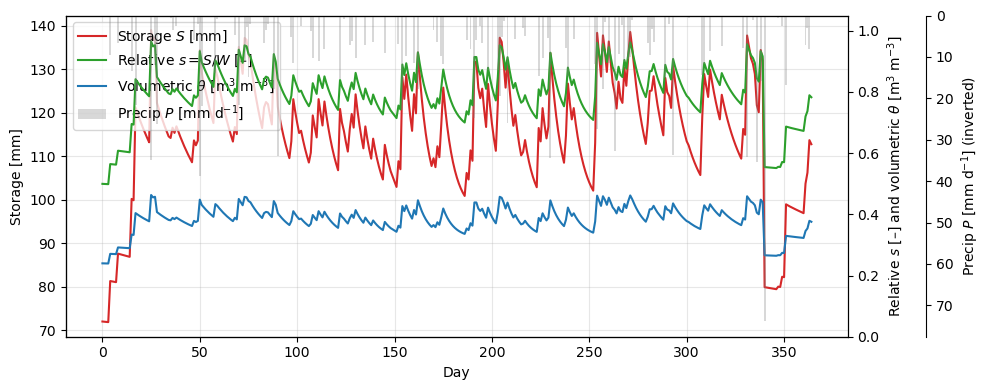

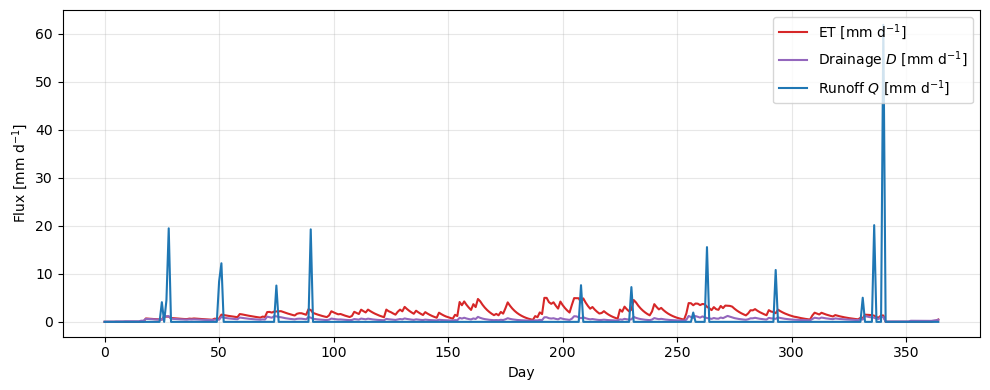

In [50]:
# Compute relative soil moisture s = S/W (use the 's' series if simulate_bucket already returns it)
if "s" in out:
    s_rel = out["s"]
else:
    W = out["W"] if "W" in out else np.full_like(out["S"], pars.porosity * pars.root_depth_m * 1000.0)
    s_rel = out["S"] / W

# Volumetric soil moisture theta [m^3 m^-3]
theta = s_rel * pars.porosity

# --- Plot 1: Storage (S), relative s, volumetric theta, and precipitation ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(out["S"], label="Storage $S$ [mm]", color="tab:red")
ax.set_ylabel("Storage [mm]")
ax.set_xlabel("Day")
ax.grid(True, alpha=0.3)

# Secondary axis (right) for s and theta
ax2 = ax.twinx()
ax2.plot(s_rel, linestyle="-", color="tab:green", label="Relative $s=S/W$ [–]")
ax2.plot(theta, linestyle="-", color="tab:blue", label=r"Volumetric $\theta$ [m$^3$ m$^{-3}$]")
ax2.set_ylabel(r"Relative $s$ [–] and volumetric $\theta$ [m$^3$ m$^{-3}$]")
ax2.set_ylim(0, 1.05)  # keeps s in [0,1]; theta will sit below porosity

# Third axis for precipitation (inverted)
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))  # offset to the right
ax3.bar(np.arange(len(P)), P, width=1.0, alpha=0.3, color="tab:gray", label=r"Precip $P$ [mm d$^{-1}$]")
ax3.invert_yaxis()  # precipitation downward
ax3.set_ylabel(r"Precip $P$ [mm d$^{-1}$] (inverted)")

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc="upper left")

fig.tight_layout()
plt.show()

# --- Plot 2: Daily fluxes (ET, D, Q) ---
fig2, ax4 = plt.subplots(figsize=(10, 4))
ax4.plot(out["ET"], label=r"ET [mm d$^{-1}$]", color="tab:red")
ax4.plot(out["D"],  label=r"Drainage $D$ [mm d$^{-1}$]", color="tab:purple")
ax4.plot(out["Q"],  label=r"Runoff $Q$ [mm d$^{-1}$]", color="tab:blue")
ax4.set_ylabel(r"Flux [mm d$^{-1}$]")
ax4.set_xlabel("Day")
ax4.grid(True, alpha=0.3)
ax4.legend(loc="upper right")

fig2.tight_layout()
plt.show()

## 12. Two-layer bucket model

The one-layer bucket represents the **entire root zone** as a single storage, which is fine for long-term water balance but does not capture the fast dynamics of the **surface layer** (0–5 cm) that satellites observe.  
A **two-layer bucket** separates the soil into:

- **Layer 1 (surface):** thin top layer (e.g. 0–0.05 m).  
  Receives precipitation, produces evaporation and some transpiration, drains into the root zone, and can generate runoff.  
  This layer dries and wets rapidly — consistent with satellite retrievals.

- **Layer 2 (root zone):** deeper reservoir (e.g. 0–0.50 m).  
  Receives percolation from the surface layer, supplies transpiration, and drains to deeper groundwater.  
  This layer buffers plant water supply and controls seasonal water balance.

---

### Governing processes

1. **Precipitation and infiltration**
   - Rainfall $P_t$ enters the **surface layer** first.  
   - Infiltration $I_{1,t}$ fills the surface storage $S_1$ up to its capacity $W_1 = \theta_{sat,1} Z_{r,1} 1000$.  
   - Any excess becomes runoff $Q_t$ or is limited by infiltration capacity (if Horton mode is used).

2. **Evapotranspiration partitioning**
   - The atmosphere first draws from the surface:  
     $ET_{1,t} = PET_t \cdot f_{ET}(s_{1,t})$, where $s_{1,t} = S_{1,t}/W_1$.  
   - Remaining demand is met by the root zone:  
     $ET_{2,t} = (PET_t - ET_{1,t}) \cdot f_{ET}(s_{2,t})$, where $s_{2,t} = S_{2,t}/W_2$.

3. **Vertical coupling**
   - Drainage from surface to root:  
     $D_{12,t} = K_{s,1} \, s_{1,t}^{\beta_1}$.  
   - This flux is an **input** to the root zone.

4. **Root zone drainage**
   - Root zone also drains to deep soil/groundwater:  
     $D_{2,t} = K_{s,2} \, s_{2,t}^{\beta_2}$.

5. **State updates**
   - Surface:  
     $S_{1,t+1} = \mathrm{clip}(S_{1,t} + I_{1,t} - ET_{1,t} - D_{12,t} - Q_t,\, 0, W_1)$.  
   - Root:  
     $S_{2,t+1} = \mathrm{clip}(S_{2,t} + D_{12,t} - ET_{2,t} - D_{2,t},\, 0, W_2)$.

---

### Parameters

Each layer requires its own `BucketParams`:
- $\theta_{sat}$, $\theta_{fc}$, $\theta_w$, $s_w$, $s_{fc}$ → estimated via **Saxton–Rawls PTF with clipping**.  
- $K_s$, $\beta$ → estimated via **texture-based priors** (`smooth`, `lookup`, or `coarse_lookup`).  
- $Z_r$ → layer depth (e.g. 0.05 m for surface, 0.50 m for root).  
- `infil_capacity` (optional) → only if `runoff_type="horton"`.

---

### Typical setup

- **Surface layer**: $Z_r = 0.05$ m, $density\_factor \approx 1.05$ (slight compaction), $K_s$ may be increased slightly (factor 1.2–1.5) to represent faster percolation.  
- **Root layer**: $Z_r = 0.50$ m (or site-specific), $density\_factor \approx 1.0$, $K_s,\beta$ from priors without scaling.

---

### Outputs

The two-layer simulation returns daily time series:
- $S_1, S_2$ [mm]: storages for surface and root.  
- $s_1, s_2$ [–]: relative moisture.  
- $ET_1, ET_2$ [mm d$^{-1}$]: evapotranspiration components.  
- $D_{12}$ [mm d$^{-1}$]: percolation surface → root.  
- $D_2$ [mm d$^{-1}$]: root drainage to deep soil.  
- $Q$ [mm d$^{-1}$]: runoff.  
- $I_1$ [mm d$^{-1}$]: infiltration into the surface.  
- $W_1, W_2$ [mm]: capacities of each layer.

---

### When to use

- **1-layer (root zone only):** good for seasonal water balance, recharge, plant stress, but not for satellite surface comparison.  
- **2-layer:** necessary if you want both **satellite-comparable surface soil moisture** (0–5 cm) and **root-zone water availability** for ET and drought.

In [51]:
def simulate_two_layer_surface(
    P: np.ndarray,
    PET: np.ndarray,
    pars_surf,                 # BucketParams for surface layer (e.g., Zr = 0.05 m)
    pars_root,                 # BucketParams for root layer   (e.g., Zr = 0.50 m)
    runoff_type: str = "saturation",  # "saturation" or "horton"
    S1_0: Optional[float] = None,     # optional initial storage [mm] for surface
    S2_0: Optional[float] = None,     # optional initial storage [mm] for root
) -> Dict[str, np.ndarray]:
    """
    Two-layer bucket:
      - Layer 1 (surface) receives precipitation, produces ET1 & runoff, percolates D12 to root.
      - Layer 2 (root) receives D12, produces ET2 & deep drainage D2.

    P, PET: arrays [T] in mm d^-1
    pars_surf / pars_root: BucketParams with fields:
        porosity (~theta_sat), root_depth_m, s_w, s_fc, K_s, beta, (optional) infil_capacity
    runoff_type:
        "saturation": Q = max(0, S1 + P - W1), I1 = min(P, max(0, W1 - S1))
        "horton":     I1 = min(P, infil_capacity), Q = max(0, P - I1)
    Returns dict with time series:
        S1,S2  [mm]; s1,s2 [–]; ET1,ET2,D12,D2,Q,I1 [mm d^-1]; optionally W1,W2 (constants)
    """
    P   = np.asarray(P, dtype=float)
    PET = np.asarray(PET, dtype=float)
    T   = len(P)
    if len(PET) != T:
        raise ValueError("P and PET must have the same length")

    # capacities
    W1 = pars_surf.porosity * pars_surf.root_depth_m * 1000.0
    W2 = pars_root.porosity * pars_root.root_depth_m * 1000.0

    # initial storages
    S1 = W1 * 0.5 if S1_0 is None else float(np.clip(S1_0, 0.0, W1))
    S2 = W2 * 0.5 if S2_0 is None else float(np.clip(S2_0, 0.0, W2))

    # outputs
    out = dict(
        S1=np.zeros(T), S2=np.zeros(T),
        s1=np.zeros(T), s2=np.zeros(T),
        ET1=np.zeros(T), ET2=np.zeros(T),
        D12=np.zeros(T), D2=np.zeros(T),
        Q=np.zeros(T), I1=np.zeros(T),
        W1=np.full(T, W1), W2=np.full(T, W2),
    )

    # helper for ET stress
    def f_et(s, s_w, s_fc):
        if s <= s_w: return 0.0
        if s >= s_fc: return 1.0
        denom = max(1e-9, (s_fc - s_w))
        return (s - s_w) / denom

    for t in range(T):
        # states and relative moisture
        S1 = float(np.clip(S1, 0.0, W1))
        S2 = float(np.clip(S2, 0.0, W2))
        s1 = S1 / W1
        s2 = S2 / W2

        # 1) ET from surface FIRST
        ET1 = PET[t] * f_et(s1, pars_surf.s_w, pars_surf.s_fc)

        # 2) Surface drainage to root (vertical coupling)
        D12 = pars_surf.K_s * (s1 ** pars_surf.beta)

        # 3) Rainfall on surface: infiltration & runoff
        if runoff_type == "saturation":
            Q  = max(0.0, S1 + P[t] - W1)
            I1 = min(P[t], max(0.0, W1 - S1))
        elif runoff_type == "horton":
            fc = np.inf if getattr(pars_surf, "infil_capacity", None) in (None, np.inf) \
                 else float(pars_surf.infil_capacity)
            I1 = min(P[t], fc)
            Q  = max(0.0, P[t] - I1)
        else:
            raise ValueError("runoff_type must be 'saturation' or 'horton'")

        # 4) Update surface storage
        S1_new = np.clip(S1 + I1 - ET1 - D12 - Q, 0.0, W1)

        # 5) Remaining PET goes to ROOT
        PET_rem = max(0.0, PET[t] - ET1)
        ET2 = PET_rem * f_et(s2, pars_root.s_w, pars_root.s_fc)

        # 6) Root drainage to deep
        D2 = pars_root.K_s * (s2 ** pars_root.beta)

        # 7) Update root storage (gain from D12)
        S2_new = np.clip(S2 + D12 - ET2 - D2, 0.0, W2)

        # write outputs
        out["S1"][t]  = S1_new
        out["S2"][t]  = S2_new
        out["s1"][t]  = S1_new / W1
        out["s2"][t]  = S2_new / W2
        out["ET1"][t] = ET1
        out["ET2"][t] = ET2
        out["D12"][t] = D12
        out["D2"][t]  = D2
        out["Q"][t]   = Q
        out["I1"][t]  = I1

        # advance
        S1, S2 = S1_new, S2_new

    return out

In [52]:
# Build layer parameters from texture (examples)
pars_surf = params_from_texture_with_priors(40, 20, 2.0, root_depth_m=0.05,
                                            ks_beta_mode="coarse_lookup", density_factor=1.10)
pars_root = params_from_texture_with_priors(40, 20, 2.0, root_depth_m=0.50,
                                            ks_beta_mode="coarse_lookup", density_factor=1.00)

# Simulate
twoL = simulate_two_layer_surface(P, PET, pars_surf, pars_root, runoff_type="saturation")

# Volumetric SM (surface & root)
theta_surface = twoL["s1"] * pars_surf.porosity   # m^3 m^-3, ~0–5 cm
theta_root    = twoL["s2"] * pars_root.porosity   # m^3 m^-3, root zone

## 13. Demo: 1‑layer vs 2‑layer with the same synthetic forcing

This section builds parameters from texture, runs both the **1‑layer** and **2‑layer** models on the **same** daily forcing, and plots comparable outputs.

**What you’ll see**

- **1‑layer graphs**
  1) Storage $S$ [mm], relative moisture $s=S/W$ [–], volumetric $\theta=s\,\theta_{sat}$ [m$^3$ m$^{-3}$], and inverted precipitation $P$ [mm $d^{-1}$].  
  2) Daily fluxes: $ET$, drainage $D$, runoff $Q$ [mm $d^{-1}$].

- **2‑layer graphs**
  3) Surface $S_1$ and root $S_2$ [mm], $s_1$, $s_2$, $\theta_1=s_1\theta_{sat,1}$, $\theta_2=s_2\theta_{sat,2}$, and inverted $P$.  
  4) Daily fluxes: $ET_1$, $ET_2$, vertical percolation $D_{12}$, root drainage $D_2$, runoff $Q$ [mm $d^{-1}$].

**Assumes** you already defined:
- `params_from_texture_with_priors(...)`
- `simulate_bucket(...)` (1‑layer)
- `simulate_two_layer_surface(...)` (2‑layer)

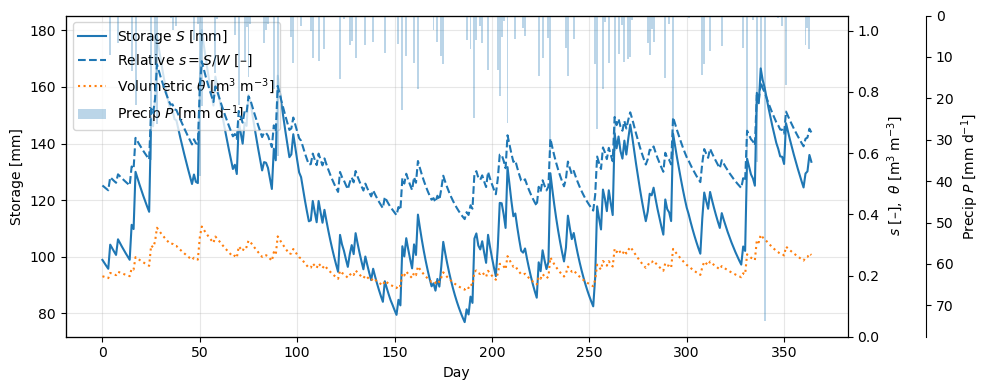

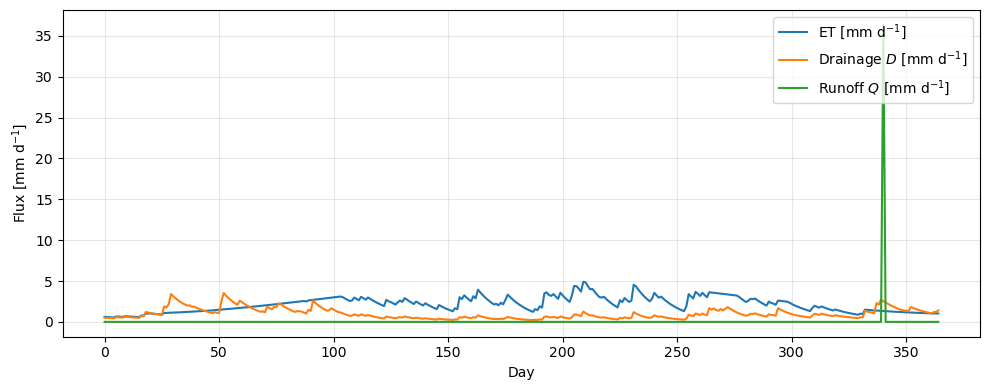

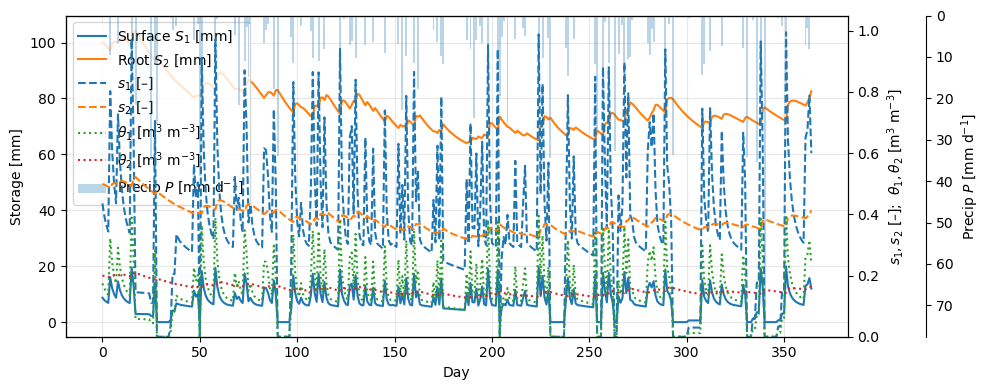

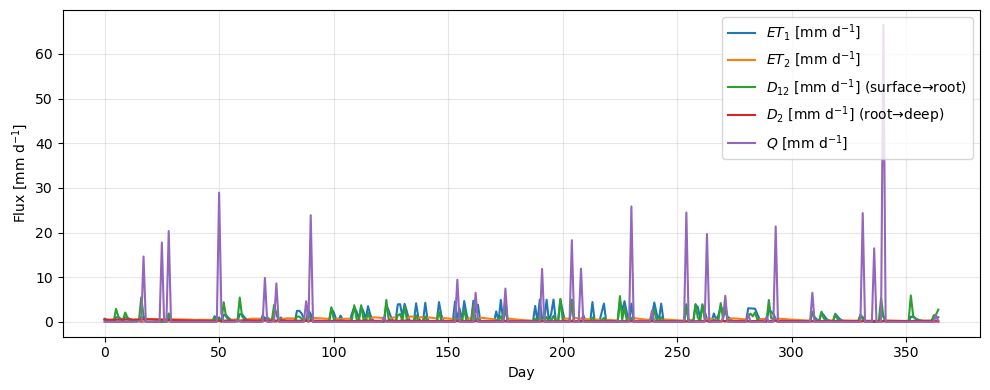

In [54]:
# --------------------------
# Synthetic forcing (1 year)
# --------------------------
T = 365
rng = np.random.default_rng(42)
wet = rng.random(T) < 0.30
P = wet * rng.exponential(scale=10.0, size=T)  # mm d^-1

days = np.arange(T)
PET = 3.0 + 2.0 * np.sin(2*np.pi*(days - 100)/365.0)
PET = np.clip(PET, 1.0, None)  # mm d^-1

# --------------------------
# Build parameters from texture
# --------------------------
# Example site texture (adjust as needed)
sand, clay, om = 40, 20, 2.0

# 1-layer: root-zone ~0.5 m
pars_1L = params_from_texture_with_priors(
    sand_pct=sand, clay_pct=clay, om_pct=om,
    root_depth_m=0.50,
    density_factor=1.0,
    ks_beta_mode="coarse_lookup"   # or "smooth" | "lookup"
)

# 2-layer: surface 0.05 m + root 0.50 m
pars_surf = params_from_texture_with_priors(
    sand_pct=sand, clay_pct=clay, om_pct=om,
    root_depth_m=0.05,
    density_factor=1.10,           # slight surface compaction (optional)
    ks_beta_mode="coarse_lookup"
)
pars_root = params_from_texture_with_priors(
    sand_pct=sand, clay_pct=clay, om_pct=om,
    root_depth_m=0.50,
    density_factor=1.0,
    ks_beta_mode="coarse_lookup"
)

# Optional: speed up surface percolation slightly (set to 1.0 to disable)
pars_surf.K_s *= 1.2

# --------------------------
# Run simulations
# --------------------------
out_1L = simulate_bucket(P, PET, params=pars_1L, runoff_type="saturation")
out_2L = simulate_two_layer_surface(P, PET, pars_surf, pars_root, runoff_type="saturation")

# --------------------------
# Helpers for derived series
# --------------------------
# 1-layer: relative and volumetric soil moisture
if "s" in out_1L:
    s_1L = out_1L["s"]
else:
    W_1L = pars_1L.porosity * pars_1L.root_depth_m * 1000.0
    s_1L = out_1L["S"] / W_1L
theta_1L = s_1L * pars_1L.porosity  # volumetric [m^3 m^-3]

# 2-layer: relative and volumetric soil moisture for each layer
s1_2L = out_2L["s1"]; s2_2L = out_2L["s2"]
theta1_2L = s1_2L * pars_surf.porosity
theta2_2L = s2_2L * pars_root.porosity

# --------------------------
# Plots
# --------------------------

# (1) 1-layer: Storage S, s, theta, and inverted precip
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(out_1L["S"], label="Storage $S$ [mm]")
ax.set_ylabel("Storage [mm]")
ax.set_xlabel("Day")
ax.grid(True, alpha=0.3)

ax_r = ax.twinx()
ax_r.plot(s_1L, linestyle="--", label="Relative $s=S/W$ [–]")
ax_r.plot(theta_1L, linestyle=":", label=r"Volumetric $\theta$ [m$^3$ m$^{-3}$]")
ax_r.set_ylabel(r"$s$ [–],  $\theta$ [m$^3$ m$^{-3}$]")
ax_r.set_ylim(0, max(1.05, pars_1L.porosity * 1.05))

ax_p = ax.twinx()
ax_p.spines["right"].set_position(("axes", 1.1))
ax_p.bar(np.arange(T), P, width=1.0, alpha=0.3, label=r"Precip $P$ [mm d$^{-1}$]")
ax_p.set_ylabel(r"Precip $P$ [mm d$^{-1}$]")
ax_p.invert_yaxis()

lines, labels = ax.get_legend_handles_labels()
lines_r, labels_r = ax_r.get_legend_handles_labels()
lines_p, labels_p = ax_p.get_legend_handles_labels()
ax.legend(lines + lines_r + lines_p, labels + labels_r + labels_p, loc="upper left")
fig.tight_layout(); plt.show()

# (2) 1-layer: Fluxes ET, D, Q
fig2, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(out_1L["ET"], label=r"ET [mm d$^{-1}$]")
ax2.plot(out_1L["D"],  label=r"Drainage $D$ [mm d$^{-1}$]")
ax2.plot(out_1L["Q"],  label=r"Runoff $Q$ [mm d$^{-1}$]")
ax2.set_ylabel(r"Flux [mm d$^{-1}$]")
ax2.set_xlabel("Day")
ax2.grid(True, alpha=0.3)
ax2.legend(loc="upper right")
fig2.tight_layout(); plt.show()

# (3) 2-layer: S1/S2, s1/s2, theta1/theta2, and inverted precip
fig3, ax3 = plt.subplots(figsize=(10, 4))
ax3.plot(out_2L["S1"], label="Surface $S_1$ [mm]")
ax3.plot(out_2L["S2"], label="Root $S_2$ [mm]")
ax3.set_ylabel("Storage [mm]")
ax3.set_xlabel("Day")
ax3.grid(True, alpha=0.3)

ax3_r = ax3.twinx()
ax3_r.plot(s1_2L, linestyle="--", label=r"$s_1$ [–]")
ax3_r.plot(s2_2L, linestyle="--", label=r"$s_2$ [–]")
ax3_r.plot(theta1_2L, linestyle=":", label=r"$\theta_1$ [m$^3$ m$^{-3}$]")
ax3_r.plot(theta2_2L, linestyle=":", label=r"$\theta_2$ [m$^3$ m$^{-3}$]")
ax3_r.set_ylabel(r"$s_1, s_2$ [–];  $\theta_1, \theta_2$ [m$^3$ m$^{-3}$]")
ax3_r.set_ylim(0, max(1.05, pars_root.porosity * 1.05))

ax3_p = ax3.twinx()
ax3_p.spines["right"].set_position(("axes", 1.1))
ax3_p.bar(np.arange(T), P, width=1.0, alpha=0.3, label=r"Precip $P$ [mm d$^{-1}$]")
ax3_p.set_ylabel(r"Precip $P$ [mm d$^{-1}$]")
ax3_p.invert_yaxis()

l3, lab3 = ax3.get_legend_handles_labels()
l3r, lab3r = ax3_r.get_legend_handles_labels()
l3p, lab3p = ax3_p.get_legend_handles_labels()
ax3.legend(l3 + l3r + l3p, lab3 + lab3r + lab3p, loc="upper left")
fig3.tight_layout(); plt.show()

# (4) 2-layer: Fluxes ET1, ET2, D12, D2, Q
fig4, ax4 = plt.subplots(figsize=(10, 4))
ax4.plot(out_2L["ET1"], label=r"$ET_1$ [mm d$^{-1}$]")
ax4.plot(out_2L["ET2"], label=r"$ET_2$ [mm d$^{-1}$]")
ax4.plot(out_2L["D12"], label=r"$D_{12}$ [mm d$^{-1}$] (surface→root)")
ax4.plot(out_2L["D2"],  label=r"$D_2$ [mm d$^{-1}$] (root→deep)")
ax4.plot(out_2L["Q"],   label=r"$Q$ [mm d$^{-1}$]")
ax4.set_ylabel(r"Flux [mm d$^{-1}$]")
ax4.set_xlabel("Day")
ax4.grid(True, alpha=0.3)
ax4.legend(loc="upper right")
fig4.tight_layout(); plt.show()

## 14. Practical guidance and typical parameter choices

(1) Root depth ($Z_r$)  
- **Crops:** 0.3–0.6 m  
- **Shrubs:** 0.5–1.0 m  
- **Forests:** often >1.0 m depending on species  
- For **satellite surface soil moisture (0–5 cm)**, set $Z_r=0.05$ m.  
- In a **2-layer setup**, use 0.05 m for the surface and 0.3–1.0 m for the root layer.

(2) Drainage parameters ($K_s, \beta$)  
- For loamy soils, typical bucket-scale values are $K_s \approx 2$–6 mm $d^{-1}$ and $\beta \approx 3$–4.  
- **Texture-based priors** (Saxton–Rawls + heuristic mapping) provide more realistic site-specific initialization.  
  - Sandy soils → higher $K_s$, lower $\beta$ (fast drainage).  
  - Clayey soils → lower $K_s$, higher $\beta$ (slow drainage, more nonlinear).  
- In 2-layer models, $K_s$ for the surface can be scaled slightly higher (e.g. ×1.2) to represent faster percolation.

(3) ET stress thresholds ($s_w, s_{fc}$)  
- Must satisfy $s_w < s_{fc}$.  
- Typical ranges:  
  - $s_w$ = 0.1–0.25 (wilting threshold).  
  - $s_{fc}$ = 0.6–0.8 (field capacity threshold).  
- Derived automatically via Saxton–Rawls PTFs, but override with site measurements if available.  
- In 2-layer models: surface ET is limited by $s_1$, and residual demand is supplied from $s_2$.

(4) PET forcing  
- Use measured PET or compute from radiation and temperature.  
- **Fallback:** Hargreaves (using only $T_{min}$ and $T_{max}$).  
- For **1-layer shallow (0–5 cm) buckets used against satellite SM**, scale PET to a soil-evaporation fraction ($\alpha_{\text{soil}} \approx 0.2$–0.5) instead of applying full PET.

(5) Initialization  
- If unknown, start $S_0 = 0.5\,W$ (half of capacity).  
- For long simulations, perform a **multi-year spin-up** by cycling the first year of forcing until soil moisture equilibrates.

(6) Upward flux / capillary rise (optional in 2-layer models)  
- Add an upward flux term $U_{21} = K_{up}(s_2 - s_1)_+$ to allow water transfer from the root zone to surface when the root zone is wetter.  
- Typical $K_{up}$ = 1–3 mm $d^{-1}$ (capillary conductivity).  
- Helps prevent the surface from drying unrealistically to zero during long drydowns in fine soils or shallow water table conditions.

---
**Rule of thumb:**  
- Use **1-layer (deep)** for water balance and drought studies.  
- Use **1-layer shallow (0–5 cm)** for satellite surface SM comparisons (with PET scaling).  
- Use **2-layer** if you want both — satellite-comparable surface soil moisture *and* a physically realistic root zone for ET partitioning.

## 15. Realistic PET: Hargreaves equation

If you do not have $PET$, you can compute a simple $PET$ using only daily $T_{min}$ and $T_{max}$ and an estimate of extraterrestrial radiation $R_a$ (MJ $m^{-2}$ $d^{-1}$). Units are mm d$^{-1}$ using the usual $0.408$ conversion from MJ $m^{-2}$ $d^{-1}$ to mm $d^{-1}$.

The simplified Hargreaves form used here is:
$$
PET = 0.0023 \,(T_{mean} + 17.8)\,\sqrt{T_{max}-T_{min}}\,R_a \times 0.408.
$$

### Formulas

Daily extraterrestrial radiation (latitude $\varphi$ in radians, day $J$):
\[
\begin{aligned}
d_r &= 1 + 0.033 \cos\!\left(\tfrac{2\pi J}{365}\right),\\
\delta &= 0.409 \sin\!\left(\tfrac{2\pi J}{365} - 1.39\right),\\
\omega_s &= \arccos\!\big(-\tan\varphi \,\tan\delta\big),\\
R_a &= \frac{24\cdot 60}{\pi}\, G_{sc}\, d_r \left[\omega_s \sin\varphi \sin\delta + \cos\varphi \cos\delta \sin\omega_s \right],
\end{aligned}
\]
with $G_{sc}=0.0820$ MJ $m^{-2}$ $min^{-1}$.

Hargreaves–Samani reference ET (≈ PET here), in mm $d^{-1}$:
$$
ET_0 = 0.0023 \,(T_{mean} + 17.8)\,\sqrt{\max(0,\,T_{max}-T_{min})}\,R_a \times 0.408.
$$

### Notes
- Output is **reference ET** (FAO-56 Hargreaves–Samani). If you have $ET_0$ and want **bare-soil evaporation demand** for a 0–5 cm bucket, scale by a soil fraction $\alpha_{soil}$ (e.g., 0.2–0.5):  
  $$
  PET_{soil} = \alpha_{soil} \, ET_0.
  $$
- High latitudes: we clamp the $\arccos$ argument to $[-1,1]$ to avoid NaNs during polar day/night.  
- Day-of-year: pass an array (1–365). If you pass only latitude, we recycle days mod 365 for long series.

Common pitfalls & tips
- Leap years: FAO‑56 uses 365 in the radiation terms; for leap years you can either (a) repeat day 59 or (b) map 366→365 and leave the formula unchanged (the small error is negligible for PET).
- High latitudes: in polar day/night, the \arccos argument may slightly exceed [-1,1] numerically; clipping keeps R_a finite.
- Units: This returns mm $d^{-1}$ (same as your bucket).
- Surface vs root‑zone demand: if you run a surface (0–5 cm) 1‑layer to compare with satellites, consider a soil‑evaporation fraction of PET (e.g., PET_soil = 0.3 * PET) rather than full PET (which includes transpiration).

In [59]:
def extraterrestrial_radiation_MJm2d(lat_deg, day_of_year):
    """
    Vectorized FAO-56 extraterrestrial radiation Ra [MJ m^-2 d^-1].

    Parameters
    ----------
    lat_deg : float or array-like
        Latitude in degrees (-90..90). If array, must be broadcastable to day_of_year.
    day_of_year : int or array-like
        Day of year (1..365). Can be any integer array; values are used modulo 365.

    Returns
    -------
    Ra : ndarray
        Extraterrestrial radiation [MJ m^-2 d^-1], same shape as broadcast(lat_deg, day_of_year).
    """
    lat = np.deg2rad(np.asarray(lat_deg, dtype=float))
    J = np.asarray(day_of_year, dtype=float)
    # Wrap J to 1..365 to avoid drift on long sequences
    J = ((J - 1) % 365) + 1

    dr = 1.0 + 0.033 * np.cos(2.0 * np.pi * J / 365.0)
    delta = 0.409 * np.sin(2.0 * np.pi * J / 365.0 - 1.39)
    phi = lat

    # Sunset hour angle with safe clip to [-1, 1]
    x = -np.tan(phi) * np.tan(delta)
    x = np.clip(x, -1.0, 1.0)
    omega_s = np.arccos(x)

    G_sc = 0.0820  # MJ m^-2 min^-1
    Ra = (24.0 * 60.0 / np.pi) * G_sc * dr * (
        omega_s * np.sin(phi) * np.sin(delta) +
        np.cos(phi) * np.cos(delta) * np.sin(omega_s)
    )
    return Ra  # MJ m^-2 d^-1

def PET_hargreaves(Tmin, Tmax, lat_deg, day_of_year=None):
    """
    Vectorized FAO-56 Hargreaves–Samani PET (ET0) in mm d^-1.

    Parameters
    ----------
    Tmin, Tmax : array-like
        Daily min/max air temperature [°C]. Same shape.
    lat_deg : float
        Latitude in degrees (-90..90).
    day_of_year : array-like or None
        Day-of-year (1..365) for each day. If None, assumes a repeating 365-day calendar
        starting at J=1 for index 0.

    Returns
    -------
    PET : ndarray
        Daily PET (ET0) [mm d^-1], same shape as Tmin/Tmax.
    """
    Tmin = np.asarray(Tmin, dtype=float).ravel()
    Tmax = np.asarray(Tmax, dtype=float).ravel()
    if Tmin.shape != Tmax.shape:
        raise ValueError("Tmin and Tmax must have the same shape")

    n = Tmin.size
    if day_of_year is None:
        J = (np.arange(n) % 365) + 1
    else:
        J = np.asarray(day_of_year, dtype=float).ravel()
        if J.size != n:
            raise ValueError("day_of_year must have the same length as Tmin/Tmax")

    Tmean = 0.5 * (Tmin + Tmax)
    Trange = np.maximum(0.0, Tmax - Tmin)

    Ra = extraterrestrial_radiation_MJm2d(lat_deg, J)  # MJ m^-2 d^-1
    # 0.408 converts MJ m^-2 d^-1 to mm d^-1 (lambda ≈ 2.45 MJ/kg)
    PET = 0.0023 * (Tmean + 17.8) * np.sqrt(Trange) * Ra * 0.408
    return PET.reshape(Tmin.shape)

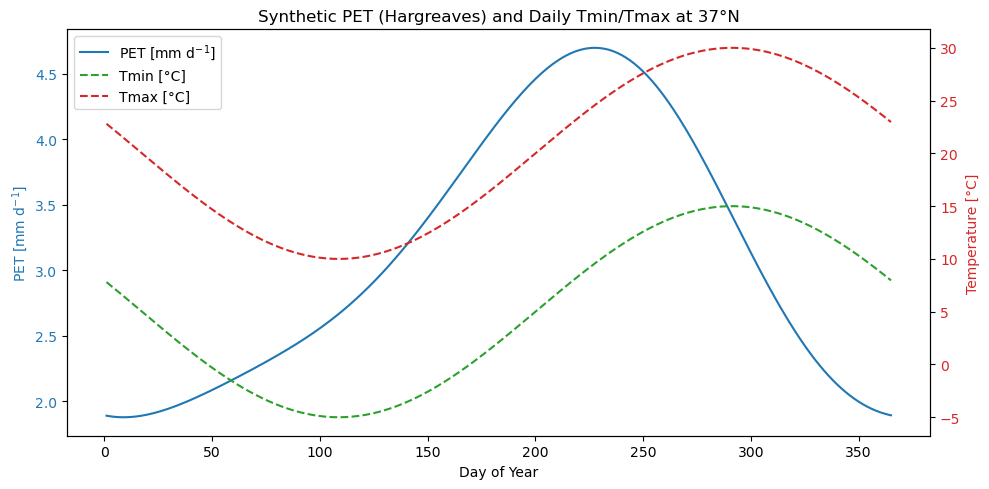

In [60]:
T = 365
days = np.arange(1, T+1)
Tmin = 10 + 10*np.sin(2*np.pi*(days-200)/365) - 5
Tmax = 10 + 10*np.sin(2*np.pi*(days-200)/365) + 10

# Compute PET
PET = PET_hargreaves(Tmin, Tmax, lat_deg=37.0, day_of_year=days)

# Plot PET and temperature ranges
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(days, PET, color="tab:blue", label="PET [mm d$^{-1}$]")
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("PET [mm d$^{-1}$]", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(days, Tmin, color="tab:green", linestyle="--", label="Tmin [°C]")
ax2.plot(days, Tmax, color="tab:red", linestyle="--", label="Tmax [°C]")
ax2.set_ylabel("Temperature [°C]", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Synthetic PET (Hargreaves) and Daily Tmin/Tmax at 37°N")
plt.tight_layout()
plt.show()

## 16. Demo: 2-layer bucket with synthetic precipitation and temperature-driven PET

This demo builds **surface (0–5 cm)** and **root (e.g., 0–50 cm)** parameters from texture, drives the model with:
- synthetic daily **precipitation** $P$ [mm $d^{-1}$],
- **Hargreaves PET** computed from synthetic $(T_{min}, T_{max})$ and latitude,

then plots:
1) Storages $S_1, S_2$ [mm], relative moisture $s_1, s_2$ [–], volumetric $\theta_1 = s_1 \theta_{sat,1}$, $\theta_2 = s_2 \theta_{sat,2}$ [$m^3$ $m^{-3}$], and inverted precipitation $P$.  
2) Fluxes $ET_1, ET_2, D_{12}, D_2, Q$ [mm $d^{-1}$] and a reference $PET$ line [mm $d^{-1}$].

### Notes
- Use your site texture for `sand_pct, clay_pct, om_pct`.  
- The 2-layer stepper draws **$ET$ from the surface first**; the remainder is taken from the root layer automatically.  

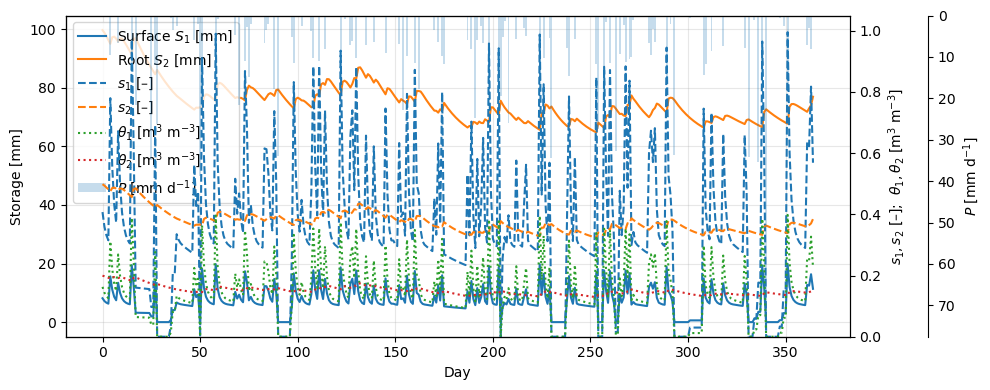

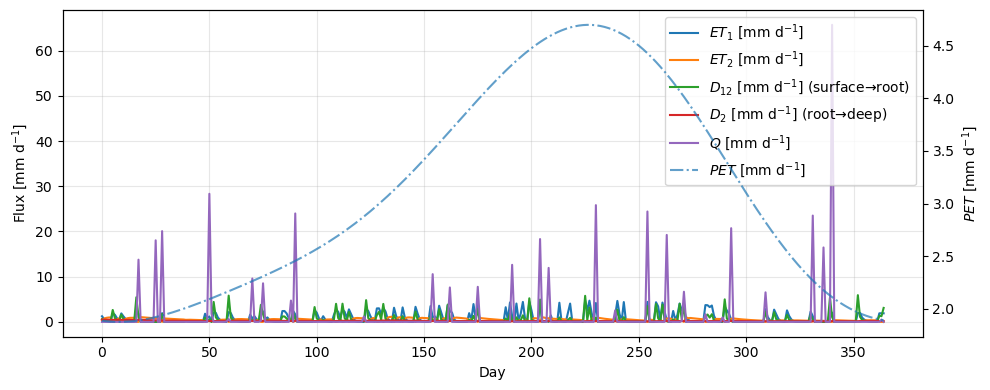

In [64]:
# --- Assumes these are already defined from earlier cells ---
# params_from_texture_with_priors(...)
# simulate_two_layer_surface(...)
# (and their dependencies like BucketParams, ks_beta_priors_from_texture, etc.)
# --------------------------
# Synthetic forcing (1 year)
# --------------------------
T = 365
days = np.arange(1, T+1)

# Smooth seasonal temperatures (°C)
Tmin = 10 + 10*np.sin(2*np.pi*(days-200)/365.0) - 5
Tmax = 10 + 10*np.sin(2*np.pi*(days-200)/365.0) + 10

# PET from Hargreaves at 37°N
PET = PET_hargreaves(Tmin, Tmax, lat_deg=37.0, day_of_year=days)  # mm d^-1

# Stochastic precipitation: 30% wet days, exponential amounts
rng = np.random.default_rng(42)
wet = rng.random(T) < 0.30
P = wet * rng.exponential(scale=10.0, size=T)  # mm d^-1

# --------------------------
# Build 2-layer parameters from texture
# --------------------------
# Example texture (adjust for your site)
sand_pct, clay_pct, om_pct = 40, 20, 2.0

# Surface (0–5 cm)
pars_surf = params_from_texture_with_priors(
    sand_pct=sand_pct, clay_pct=clay_pct, om_pct=om_pct,
    root_depth_m=0.05,
    density_factor=1.10,            # slight compaction near surface (optional)
    ks_beta_mode="coarse_lookup"    # or "smooth" | "lookup"
)
# Optional: slightly faster percolation in surface
pars_surf.K_s *= 1.2

# Root (e.g., 0–50 cm)
pars_root = params_from_texture_with_priors(
    sand_pct=sand_pct, clay_pct=clay_pct, om_pct=om_pct,
    root_depth_m=0.50,
    density_factor=1.00,
    ks_beta_mode="coarse_lookup"
)

# --------------------------
# Run the 2-layer model
# --------------------------
twoL = simulate_two_layer_surface(P, PET, pars_surf, pars_root, runoff_type="saturation")

# Derived volumetric soil moisture
theta1 = twoL["s1"] * pars_surf.porosity
theta2 = twoL["s2"] * pars_root.porosity

# --------------------------
# Plots
# --------------------------

# (1) Storages (S1,S2), relative (s1,s2), volumetric (theta1,theta2), and inverted precip
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(twoL["S1"], label="Surface $S_1$ [mm]")
ax.plot(twoL["S2"], label="Root $S_2$ [mm]")
ax.set_ylabel("Storage [mm]")
ax.set_xlabel("Day")
ax.grid(True, alpha=0.3)

axr = ax.twinx()
axr.plot(twoL["s1"], linestyle="--", label=r"$s_1$ [–]")
axr.plot(twoL["s2"], linestyle="--", label=r"$s_2$ [–]")
axr.plot(theta1, linestyle=":", label=r"$\theta_1$ [m$^3$ m$^{-3}$]")
axr.plot(theta2, linestyle=":", label=r"$\theta_2$ [m$^3$ m$^{-3}$]")
axr.set_ylabel(r"$s_1, s_2$ [–];  $\theta_1, \theta_2$ [m$^3$ m$^{-3}$]")
axr.set_ylim(0, max(1.05, pars_root.porosity*1.05))

axp = ax.twinx()
axp.spines["right"].set_position(("axes", 1.1))
axp.bar(np.arange(T), P, width=1.0, alpha=0.25, label=r"$P$ [mm d$^{-1}$]")
axp.set_ylabel(r"$P$ [mm d$^{-1}$]")
axp.invert_yaxis()

l1, lab1 = ax.get_legend_handles_labels()
l2, lab2 = axr.get_legend_handles_labels()
l3, lab3 = axp.get_legend_handles_labels()
ax.legend(l1 + l2 + l3, lab1 + lab2 + lab3, loc="upper left")
fig.tight_layout(); plt.show()

# (2) Fluxes: ET1, ET2, D12, D2, Q and PET
fig2, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(twoL["ET1"], label=r"$ET_1$ [mm d$^{-1}$]")
ax2.plot(twoL["ET2"], label=r"$ET_2$ [mm d$^{-1}$]")
ax2.plot(twoL["D12"], label=r"$D_{12}$ [mm d$^{-1}$] (surface→root)")
ax2.plot(twoL["D2"],  label=r"$D_2$ [mm d$^{-1}$] (root→deep)")
ax2.plot(twoL["Q"],   label=r"$Q$ [mm d$^{-1}$]")
ax2.set_ylabel(r"Flux [mm d$^{-1}$]")
ax2.set_xlabel("Day")
ax2.grid(True, alpha=0.3)
ax2.legend(loc="upper left")

ax2r = ax2.twinx()
ax2r.plot(PET, linestyle="-.", alpha=0.7, label=r"$PET$ [mm d$^{-1}$]")
ax2r.set_ylabel(r"$PET$ [mm d$^{-1}$]")

l4, lab4 = ax2.get_legend_handles_labels()
l5, lab5 = ax2r.get_legend_handles_labels()
ax2.legend(l4 + l5, lab4 + lab5, loc="upper right")

fig2.tight_layout(); plt.show()

### 16. Final notes and next steps

**Calibration.**  
If you have observed soil moisture time series, calibrate $K_s$, $\beta$, and effective root depth $Z_r$ by minimizing a loss function such as RMSE of relative soil moisture $s = S/W$.  
Optionally include a bias term for $PET$ if your $PET$ estimates are uncertain. For satellite comparison (0–5 cm), scale PET to a soil-evaporation fraction $\alpha_{soil}$.

**Snow and frozen soil.**  
If your region has snow, add a degree-day snow module: precipitation below 0C is routed to a snow store, then released as melt $P$ when T > 0C.  
Frozen soil physics can be represented by restricting infiltration when $T < 0C, forcing precipitation to generate runoff rather than entering storage.

**Two-layer bucket.**  
We extended the model into **two layers**:  
- **Surface layer (0–5 cm)**: responds rapidly to $P$ and $PET$, represents satellite-observable SM.  
- **Root layer (e.g., 0–50 cm)**: supplies most transpiration and controls seasonal water availability.  
Coupling is downward ($D_{12}$ from surface to root). Surface ET is satisfied first; the remainder of $PET$ is drawn from the root layer ($ET_2$).  
Runoff occurs from the surface bucket when $S_1 > W_1$ (saturation excess).

**Capillary rise (upward flux).**  
To better capture long drydowns, add an upward flux from root to surface:  
$$
U_{21} = K_{up} \,(s_2 - s_1)_+,
$$  
added to the surface and subtracted from the root zone. Typical $K_{up}$ is 1–3 mm d$^{-1}$ in fine soils or shallow water tables.  
Without $U_{21}$, the surface dries to zero and stays there until the next rain.

**Richards’ equation upgrade.**  
The two-layer bucket is a lumped approximation of the 1D Richards’ equation:  
$$
\frac{\partial \theta}{\partial t} = \frac{\partial}{\partial z}\!\left[K(\theta)\Big(\frac{\partial h}{\partial z}+1\Big)\right] - S_r(z,t).
$$  
A Richards-based solver resolves infiltration fronts, redistribution, and capillary rise automatically using soil hydraulic functions (van Genuchten–Mualem or Clapp–Hornberger).  
This is more computationally expensive but more physically robust for global or climate-scale modeling.

**Routing model.**  
To connect local water balance to streamflow, route the daily runoff flux $Q_t$ through a **routing scheme** (linear reservoir, Muskingum–Cunge, kinematic wave).  
This enables simulation of basin hydrographs and comparison to discharge observations.

---

This notebook provides a **baseline framework**:  
- 1-layer (root-zone only) for seasonal water balance and drought monitoring.  
- 1-layer shallow (0–5 cm, with scaled PET) for direct comparison with satellite SM.  
- 2-layer for simultaneous **satellite-comparable surface SM** and **root-zone dynamics**.  

From here, you can extend with snow, frozen soil, capillary rise, Richards’ equation solvers, or river routing, depending on your application.
